<a href="https://colab.research.google.com/github/vijayshankarrealdeal/intro_to_pytorch-Gans/blob/main/styleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch 
import torch.nn as nn
import PIL.Image as Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [2]:
device = "cuda"
device

'cuda'

In [3]:
imsize = 224
loader = transforms.Compose([transforms.Resize(imsize), 
         transforms.ToTensor(), 
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [4]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

In [5]:
content_img = image_loader("/content/to.jpg").to(device)
style_img = image_loader('/content/1.jpg').to(device)

In [6]:
unloader = transforms.Compose([
           transforms.Normalize((-0.485/0.229, 
                                 -0.456/0.224, -0.406/0.225), 
                                (1/0.229, 1/0.224, 1/0.225)),
           transforms.ToPILImage()])

In [7]:
def tensor2image(tensor):
    image = tensor.clone() 
    image = image.squeeze(0)  
    image = unloader(image)
    return image

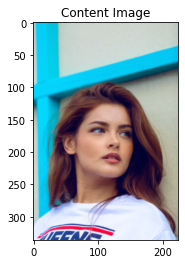

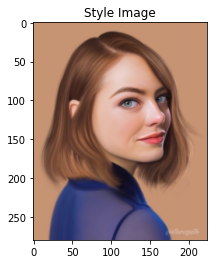

In [8]:
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()
plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [9]:
model = models.vgg19(pretrained=True).features

In [10]:
for param in model.parameters():
  param.requires_grad_(False)


In [11]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
relevant_layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

In [13]:
def features_extractor(x, model, layers):
        
    features = {}
    for index, layer in model._modules.items():
        x = layer(x)
        if index in layers:
            features[layers[index]] = x
            
    return features

In [14]:
content_features = features_extractor(content_img, model, relevant_layers)
style_features = features_extractor(style_img, model, relevant_layers)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
style_grams = {}
for i in style_features:
    layer = style_features[i]
    _, d1, d2, d3 = layer.shape
    features = layer.view(d1, d2 * d3)
    gram = torch.mm(features, features.t())
    style_grams[i] = gram

In [16]:
target_img = content_img.clone().requires_grad_(True).to(device)

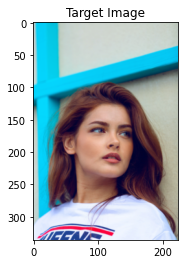

In [17]:
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title("Target Image")
plt.show()

In [18]:
style_weights = {'conv1_1': 1., 'conv2_1': 0.8, 'conv3_1': 0.6, 'conv4_1': 0.4, 'conv5_1': 0.2}

In [19]:
alpha = 1
beta = 1e5

In [20]:
print_statement = 500
optimizer = torch.optim.Adam([target_img], lr=0.001)
iterations = 5000

Total loss:  30337998.0


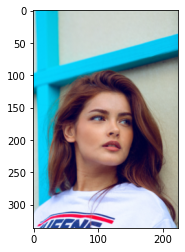

Total loss:  8912027.0


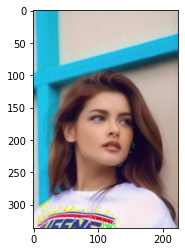

Total loss:  3951233.0


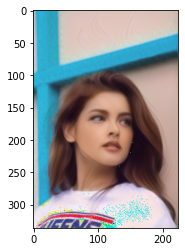

Total loss:  2002971.5


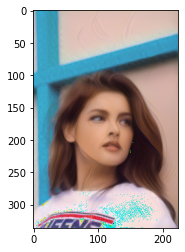

Total loss:  1117810.875


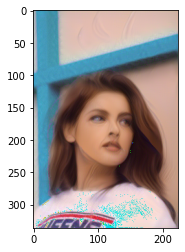

Total loss:  674586.5625


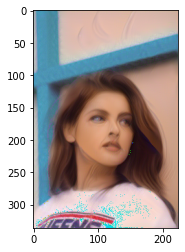

Total loss:  433664.625


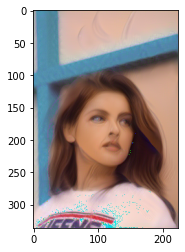

Total loss:  292905.5


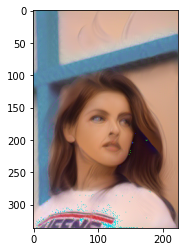

Total loss:  206948.8125


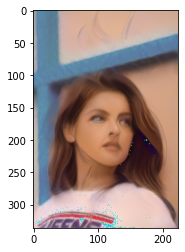

Total loss:  153360.46875


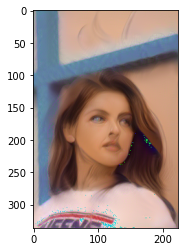

Total loss:  118858.1484375


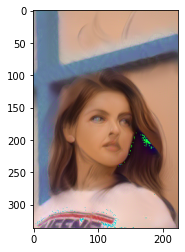

In [21]:
for i in range(1, iterations+1):
    
    target_features = features_extractor(target_img, model, relevant_layers)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_losses = 0
    for layer in style_weights:
        
        target_feature = target_features[layer]
        _, d1, d2, d3 = target_feature.shape
        
        target_reshaped = target_feature.view(d1, d2 * d3)
        target_gram = torch.mm(target_reshaped, target_reshaped.t())
        style_gram = style_grams[layer]
                
        style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_losses += style_loss / (d1 * d2 * d3)
        
    total_loss = alpha * content_loss + beta * style_losses
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  i % print_statement == 0 or i == 1:
        print('Total loss: ', total_loss.item())
        plt.imshow(tensor2image(target_img))
        plt.show()

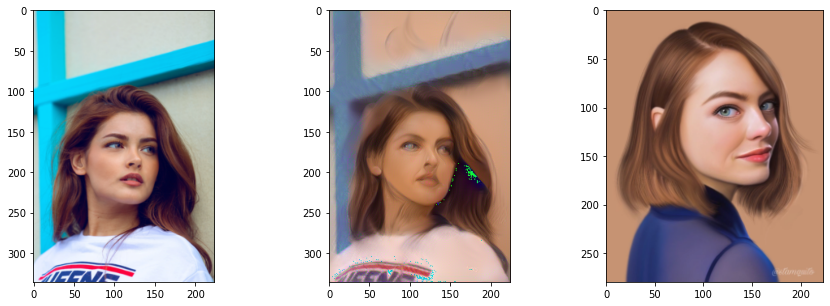

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
ax3.imshow(tensor2image(style_img))
plt.show()